In [2]:
import os
import time

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import sklearn

import audb
import audiofile
import opensmile

In [3]:
audio_file=os.path.expanduser("~/Downloads/test.wav")

In [4]:
smile = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
)

In [5]:
smile_Fctnls = opensmile.Smile(
    feature_set=opensmile.FeatureSet.eGeMAPSv02,
    feature_level=opensmile.FeatureLevel.Functionals,
)
#smile_Fctnls.feature_names

Variablen definieren, in der die Features gespeichert werden.

In [6]:
#Variable mit den LLD's
y = smile.process_file(audio_file)

In [7]:
#Variable mit den Parametern (amean, stdev, etc.) der LLD's
x = smile_Fctnls.process_file(audio_file)

Tabelle mit den Features anlegen, die für die Analyse benötigt werden.

In [8]:
tab = y.filter(
    ['F0semitoneFrom27.5Hz_sma3nz',
     'Loudness_sma3',
     'slope0-500_sma3',
     'slope500-1500_sma3',
     'mfcc1_sma3',
     'mfcc2_sma3',
     'mfcc3_sma3',
     'mfcc4_sma3',])

### Loudness

IPU's auf denen ein Turn-Shift folgt haben eine niedrigere mittlere Intensity (Lautstärke) als IPU's auf die ein Turn-Hold folgt (Intensity berechnet über die finalen 500 und 1000 ms der IPU). Der Unterschied nimmt mit dem Ende der IPU zu.

Es wird der Mittelwert der finalen 500 ms der IPU berechnet und mit dem Mittelwert der gesamten Utterance verglichen. Ist der finale Mittelwert niedriger, liegt ein Turn-Yielding Cue vor. Ist der Mittelwert höher/gleich liegt ein Turn-Holding Cue vor.

In [9]:
fname= '/Users/alexandereberhard/Downloads/test.wav'
loudnessValues = y['Loudness_sma3']
loudnessTemp = loudnessValues[fname]
loudnessTemp = list(loudnessTemp.items())

In [10]:
dataTableLoudness = {
    'start': [],
    'end': [],
    'loudness': []
}

for row in loudnessTemp:
    dataTableLoudness['start'].append(row[0][0])
    dataTableLoudness['end'].append(row[0][1])
    dataTableLoudness['loudness'].append(row[1])
    

dfLoudness = pd.DataFrame(dataTableLoudness)

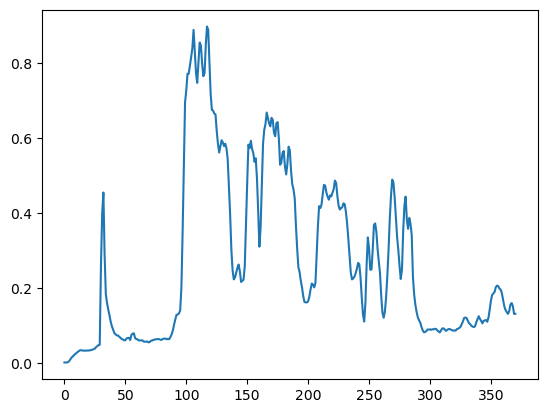

In [11]:
loudnessPlot = dfLoudness['loudness'].plot()

Sampling-Rate = 50 Hz (20ms)
Für die letzten 500 ms werden also die letzten 500ms/20ms = 25 Eintrage des Data-Frames benötigt.

In [12]:
finalLoudness = dfLoudness.tail(25)

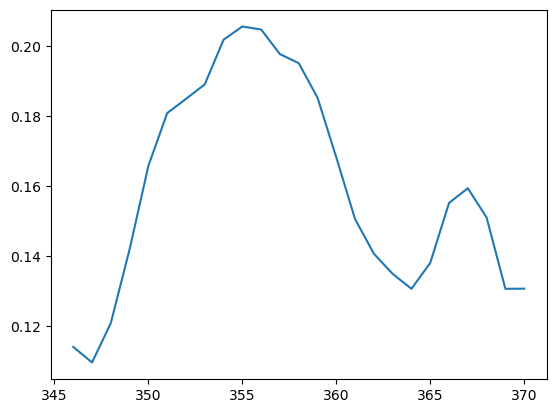

In [13]:
finalLoudnessPlot = finalLoudness['loudness'].plot()

In [14]:
finalLoudness_mean = finalLoudness['loudness'].mean()
loudness_mean = dfLoudness['loudness'].mean()

In [15]:
if finalLoudness_mean <= loudness_mean:
    loudness = 1
    print("Turn-Yielding Cue")
elif finalLoudness_mean > loudness_mean:
    loudness = 0
    print("Turn-Holding Cue")

Turn-Yielding Cue


### F0

Level intonation (in the middle of the speaker’s fundamental frequency range) tends to serve as a turn-holding cue, whereas either rising or falling pitch can be found in turn-yielding contexts

Pitch slopes were computed by fitting least-squares linear regression models to the F0 data points extracted from given portions of the signal, such as a full word or its last 200 ms

In [16]:
f0Values = y['F0semitoneFrom27.5Hz_sma3nz']
f0Temp = f0Values[fname]
f0Temp = list(f0Temp.items())

In [17]:
dataTablef0 = {
    'start': [],
    'end': [],
    'F0': []
}

for row in f0Temp:
    dataTablef0['start'].append(row[0][0])
    dataTablef0['end'].append(row[0][1])
    dataTablef0['F0'].append(row[1])
    

df_f0 = pd.DataFrame(dataTablef0)
df_f0

,start,end,F0
0,0 days 00:00:00,0 days 00:00:00.020000,0.000000
1,0 days 00:00:00.010000,0 days 00:00:00.030000,0.000000
2,0 days 00:00:00.020000,0 days 00:00:00.040000,0.000000
3,0 days 00:00:00.030000,0 days 00:00:00.050000,0.000000
4,0 days 00:00:00.040000,0 days 00:00:00.060000,0.000000
...,...,...,...
366,0 days 00:00:03.660000,0 days 00:00:03.680000,0.000000
367,0 days 00:00:03.670000,0 days 00:00:03.690000,15.610291
368,0 days 00:00:03.680000,0 days 00:00:03.700000,14.844528
369,0 days 00:00:03.690000,0 days 00:00:03.710000,13.992299


In [18]:
#timedelta = df_f0["end"] - df_f0["start"]
time = df_f0["end"].dt.total_seconds()

In [19]:
time

0      0.020000
1      0.030000
2      0.040000
3      0.050000
4      0.060000
         ...   
366    3.680000
367    3.690000
368    3.700000
369    3.710000
370    3.754671
Name: end, Length: 371, dtype: float64

<Axes: >

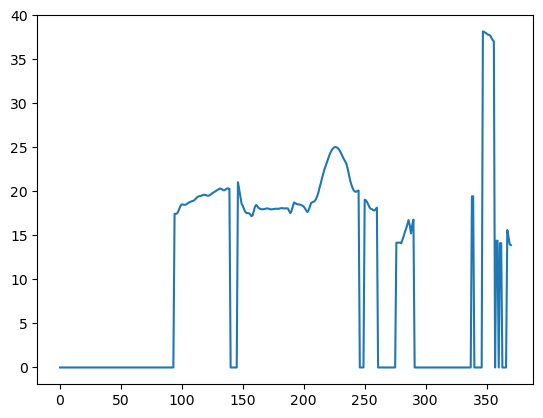

In [20]:
f0 = df_f0['F0']
f0.plot()

Pitch an den letzten 200 ms (10 Dateneinträgen)

In [21]:
from sklearn.linear_model import LinearRegression
#yReg = f0 #Alle y-Werte für Interpolation
#X = dfF0['end'].array.reshape(-1, 1) #Alle x-Werte für Interpolation
#yReg = df_f0
#x_final = df_f0['end'].tail(20).array.reshape(-1, 1) #Die letzen 20 Zeitwerte
x_final = time.tail(20).array.reshape(-1, 1)
y_final=f0.tail(20) #Die letzen 20 Werte von F0

LR = LinearRegression().fit(x_final,y_final)
coef = LR.coef_
intercept = LR.intercept_

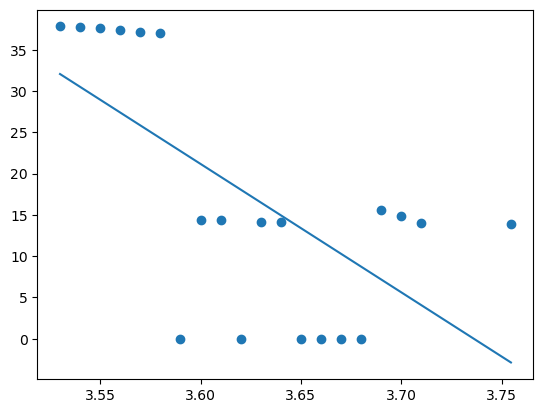

In [22]:
fig, ax = plt.subplots()
plt.scatter(x_final, y_final) #Plot der letzten Datenpunkte
LR_line = coef*x_final + intercept
ax.plot(x_final,LR_line)

In [23]:
if coef > 0:
    pitch = 1
    print("Turn-Yielding Cue")
elif coef < 0:
    pitch = 1
    print("Turn-Yielding Cue")
elif coef.isclose(0):
    pitch = 0
    print("Turn-Holding Cue")

Turn-Yielding Cue


### Spectral Slope

The spectral slope reflects how the energy in the speech signal is distributed across different frequencies.
A rising spectral slope indicates that higher frequencies carry more energy, while a falling slope suggests that lower frequencies dominate.

##### Rising Slope

When the spectral slope is rising, it means that the higher frequencies in the speech signal are becoming more prominent. This can be associated with an increase in the fundamental frequency (F0), leading to a perceived rise in pitch. Rising pitch, in turn, might be indicative of heightened emotional expression, emphasis, or a speaker's intention to yield the turn.

##### Falling Slope

A falling spectral slope suggests that lower frequencies are becoming more dominant, potentially leading to a decrease in the fundamental frequency (F0) and a perceived drop in pitch. Falling pitch might be associated with a more relaxed or conclusive tone and may not signal an upcoming turn transition.

In [24]:
slope_500_values = y['slope0-500_sma3']
slope_1500_values = y['slope500-1500_sma3']

In [25]:
slope_500_Temp = slope_500_values[fname]
slope_500_Temp = list(slope_500_Temp.items())

slope_1500_Temp = slope_1500_values[fname]
slope_1500_Temp = list(slope_1500_Temp.items())

In [26]:
dataTable_slope_500 = {
    'start': [],
    'end': [],
    'slope 0-500': []
}

for row in slope_500_Temp:
    dataTable_slope_500['start'].append(row[0][0])
    dataTable_slope_500['end'].append(row[0][1])
    dataTable_slope_500['slope 0-500'].append(row[1])
    

df_slope_500 = pd.DataFrame(dataTable_slope_500)

dataTable_slope_1500 = {
    'start': [],
    'end': [],
    'slope 500-1500': []
}

for row in slope_1500_Temp:
    dataTable_slope_1500['start'].append(row[0][0])
    dataTable_slope_1500['end'].append(row[0][1])
    dataTable_slope_1500['slope 500-1500'].append(row[1])
    

df_slope_1500 = pd.DataFrame(dataTable_slope_1500)

<Axes: >

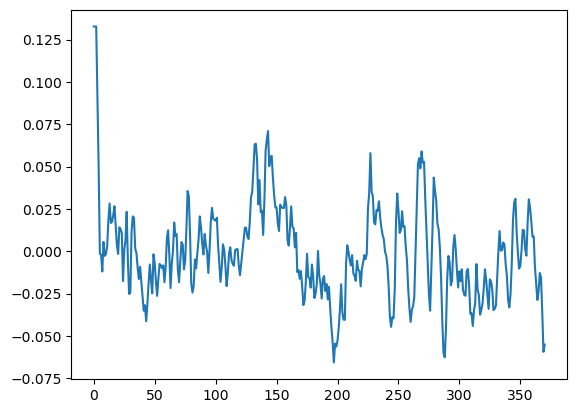

In [27]:
df_slope_500['slope 0-500'].plot()

<Axes: >

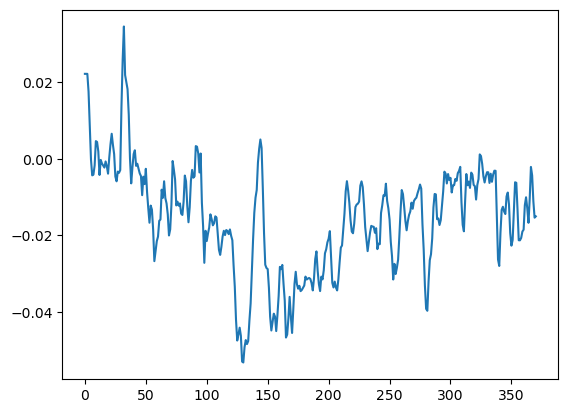

In [28]:
df_slope_1500['slope 500-1500'].plot()

In [29]:
slope_500 = df_slope_500['slope 0-500']

y_slope_500_final=slope_500.tail(20) #Die letzen 20 Werte vom slope 0-500Hz

LR_slope_500 = LinearRegression().fit(x_final,y_slope_500_final)
coef_slope_500 = LR_slope_500.coef_
intercept_slope_500 = LR_slope_500.intercept_

slope_1500 = df_slope_1500['slope 500-1500']

y_slope_1500_final=slope_1500.tail(20) #Die letzen 20 Werte vom slope 0-500Hz

LR_slope_1500 = LinearRegression().fit(x_final,y_slope_1500_final)
coef_slope_1500 = LR_slope_1500.coef_
intercept_slope_1500 = LR_slope_1500.intercept_

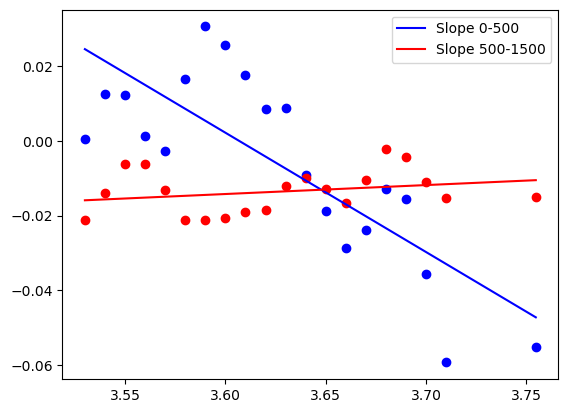

In [66]:
fig, ax = plt.subplots()

plt.scatter(x_final, y_slope_500_final, color='b') #Plot der letzten Datenpunkte
LR_slope_500_line = coef_slope_500*x_final + intercept_slope_500
ax.plot(x_final,LR_slope_500_line, color='b', label='Slope 0-500')

plt.scatter(x_final, y_slope_1500_final, color='r') #Plot der letzten Datenpunkte
LR_slope_1500_line = coef_slope_1500*x_final + intercept_slope_1500
ax.plot(x_final,LR_slope_1500_line, color='r', label='Slope 500-1500')
ax.legend()

### Turn Yield & Shift aus Slope
##### Turn Yield
1) slope 0-500 fällt & slope 500-1500 steigt
2) slope 0-500 fällt & slope 500-1500 fällt

--> slope 0-500 < 0 und 500-1500 ungleich 0
##### Turn Shift
3) slope 0-500 steigt & slope 500-1500 fällt
4) slope 0-500 steigt & slope 500-1500 steigt

--> slope 0-500 > 0 und 500-1500 ungleich 0

In [36]:
# 1 & 2
if coef_slope_500 < 0 and coef_slope_1500!=0:
    slope = 1
    print("Turn Yielding Cue")
# 2 & 3
elif coef_slope_1500 > 0 and coef_slope_1500!=0:
    slope = 0
    print("Turn Holding Cue")

Turn Yielding Cue


### MFCC

In [37]:
mfcc1_values = y['mfcc1_sma3']
mfcc2_values = y['mfcc2_sma3']

In [38]:
mfcc1_Temp = mfcc1_values[fname]
mfcc1_Temp = list(mfcc1_values.items())

mfcc2_Temp = mfcc2_values[fname]
mfcc2_Temp = list(mfcc2_values.items())

In [41]:
dataTable_mfcc1 = {
    'start': [],
    'end': [],
    'mfcc 1': []
}

for row in mfcc1_Temp:
    dataTable_mfcc1['start'].append(row[0][0])
    dataTable_mfcc1['end'].append(row[0][1])
    dataTable_mfcc1['mfcc 1'].append(row[1])
    

df_mfcc1 = pd.DataFrame(dataTable_mfcc1)

dataTable_mfcc2 = {
    'start': [],
    'end': [],
    'mfcc 2': []
}

for row in mfcc2_Temp:
    dataTable_mfcc2['start'].append(row[0][0])
    dataTable_mfcc2['end'].append(row[0][1])
    dataTable_mfcc2['mfcc 2'].append(row[1])
    

df_mfcc2 = pd.DataFrame(dataTable_mfcc2)

<Axes: >

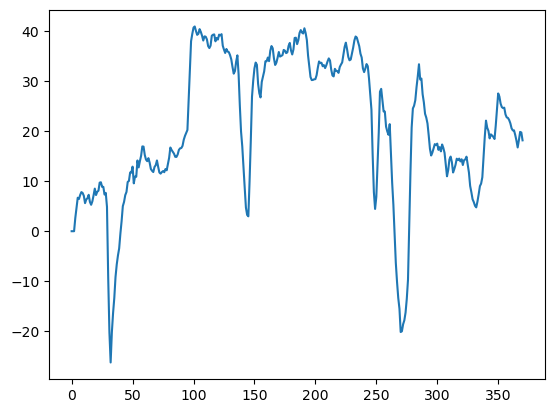

In [46]:
df_mfcc1['mfcc 1'].plot()

<Axes: >

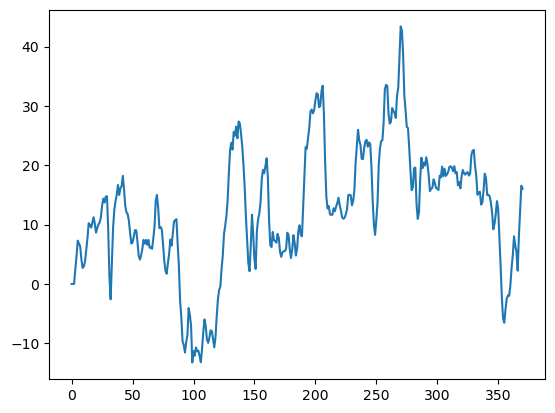

In [48]:
df_mfcc2['mfcc 2'].plot()

In [56]:
mfcc1 = df_mfcc1['mfcc 1']
mfcc2 = df_mfcc2['mfcc 2']
mfcc1_final=mfcc1.tail(20) #Die letzen 20 Werte vom MFCC 1
mfcc2_final=mfcc2.tail(20) #Die letzen 20 Werte vom MFCC 1

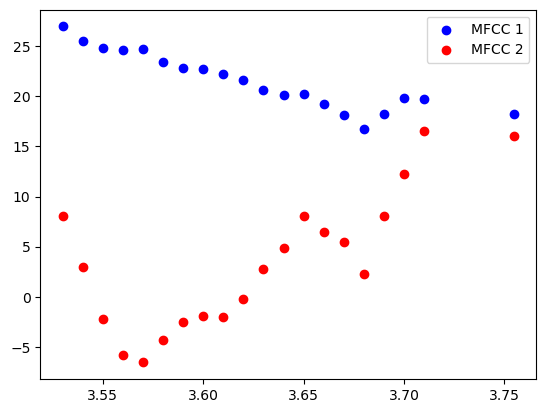

In [61]:
fig, ax = plt.subplots()
plt.scatter(x_final, mfcc1_final, color='b', label='MFCC 1') #Plot der letzten Datenpunkte
plt.scatter(x_final, mfcc2_final, color='r', label='MFCC 2') #Plot der letzten Datenpunkte
ax.legend()